#Yêu cầu chủ đề.

Xây dựng phần mềm nhận dạng 5 đối tượng trong phòng
* a. Xây dựng, thu thập tập dữ liệu các đối tượng cần nhận dạng
* b. Phân lớp các đối tượng trên
* c. Tìm gốc quay của đối tượng
* d. Triển khai mô hình (web, desktop)




# Giới thiệu.
- Tiếp nối yêu cầu của đề tài: c. Tìm gốc quay của đối tượng
- Từ dataset ban đầu, nhóm chúng em thực hiện xoay ảnh với 3 góc độ là 90, 180, 270 và ảnh gốc ban đầu sẽ là 0 độ.
- Số lượng ảnh ban đầu là 5000 ảnh, sau khi xoay sẽ tăng lên là 20 000 ảnh tương ứng với mỗi góc xoay có 5000 ảnh.


* Mục tiêu chính của bài toán phân loại này là tìm ra mối quan hệ, mẫu hoặc đặc trưng của vật ở các góc độ khác nhau trong ảnh.

# 1 - Chuẩn bị dữ liệu.

## 1.1 Tải và uzip Dataset.

In [ ]:
#https://drive.google.com/file/d/11nlOAtsKG2x_52FwYLp-XcpPiGPIME7s/view?usp=sharing
%%shell
gdown -q 11nlOAtsKG2x_52FwYLp-XcpPiGPIME7s
unzip -q Rotated_IM.zip -d /content/dataset

#Import libary

In [ ]:
import os
import shutil
import random
import progressbar
import cv2
import imutils
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from joblib import dump, load
import plotly.express as px
from google.colab import drive
from keras.models import load_model

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from keras.applications import imagenet_utils
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, Sequential, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# # Mount Google Drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Đường dẫn đến thư mục chứa dữ liệu
path_to_data = '/content/dataset/Rotated_IM'

# Đường dẫn đến thư mục chứa dữ liệu đã được chia
path_to_train = '/content/Train'
path_to_test = '/content/Test'
path_to_valid = '/content/Valid'

# Tạo các thư mục nếu chúng không tồn tại
os.makedirs(path_to_train, exist_ok=True)
os.makedirs(path_to_test, exist_ok=True)
os.makedirs(path_to_valid, exist_ok=True)

# Tạo thư mục train/test/valid cho từng class
classes = os.listdir(path_to_data)
for class_name in classes:
    os.makedirs(os.path.join(path_to_train, class_name), exist_ok=True)
    os.makedirs(os.path.join(path_to_test, class_name), exist_ok=True)
    os.makedirs(os.path.join(path_to_valid, class_name), exist_ok=True)

#Split Train - Valid - Test


In [ ]:
# Chia dữ liệu thành tập train/test/valid
for class_name in classes:
    class_path = os.path.join(path_to_data, class_name)
    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42) #train 14000(3500 1 class), test 6000
    test_images, valid_images = train_test_split(test_images, test_size=0.4, random_state=42) #test 3600 (900 1 class), valid 2400 (800)

    for image in train_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(path_to_train, class_name, image)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(path_to_test, class_name, image)
        shutil.copy(src, dest)

    for image in valid_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(path_to_valid, class_name, image)
        shutil.copy(src, dest)

#Show the amount of data

In [ ]:
def viz_class(x, NoD):
    class_names = list(filter(lambda f: os.path.isdir(os.path.join(x, f)),
                              os.listdir(x)))
    class_dis = [len(os.listdir(x + f"/{name}")) for name in class_names]
    lk_dis = dict(zip(class_names, class_dis))
    print(f"Class Distribution:\n{lk_dis}")

    fig = px.bar(x=class_dis, y=class_names, color=class_names, width=1000)
    fig.update_layout({'title': {'text': f'{NoD}', 'x': 0.5}},
                      xaxis_title="Số lượng mẫu",
                      yaxis_title="Các lớp của Dataset")
    fig.show()

In [ ]:
viz_class(path_to_train, "Train Set")

Class Distribution:
{'0': 3500, '90': 3500, '180': 3500, '270': 3500}


In [ ]:
viz_class(path_to_valid, "Valid Set")

Class Distribution:
{'0': 600, '90': 600, '180': 600, '270': 600}


In [ ]:
viz_class(path_to_test, "Test Set")

Class Distribution:
{'0': 900, '90': 900, '180': 900, '270': 900}


Found 14000 files belonging to 4 classes.


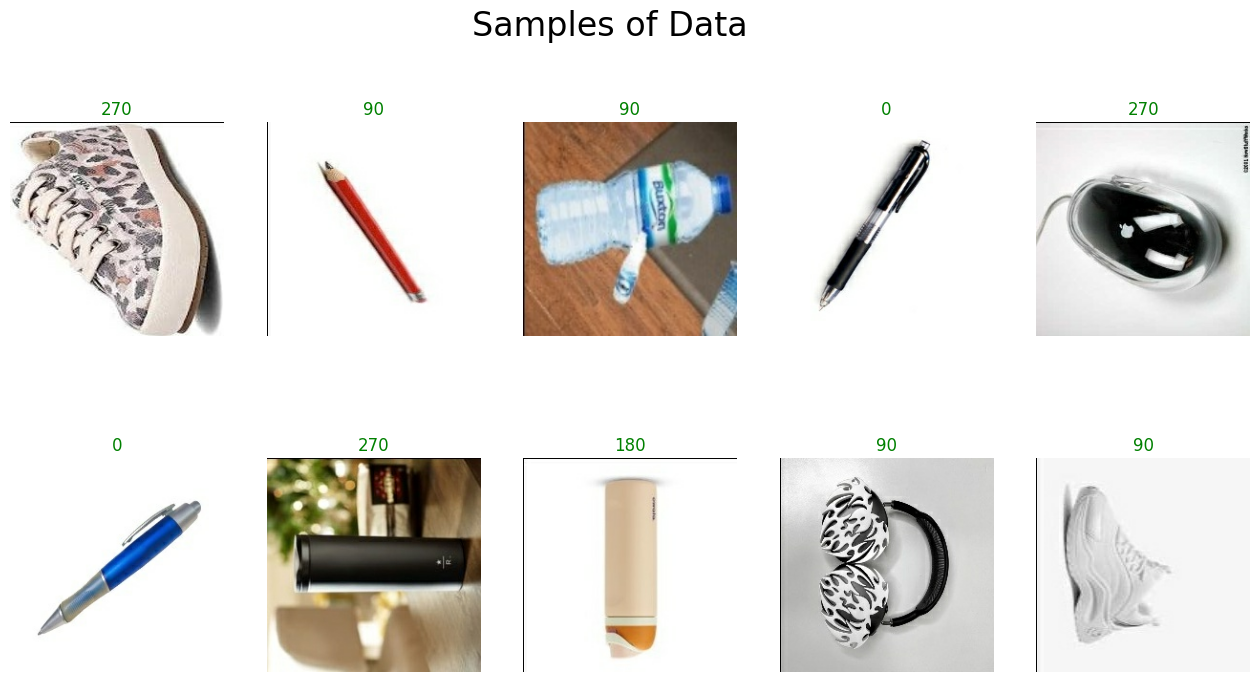

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
  path_to_train,
  image_size=(224, 224),
  batch_size=10,
  shuffle= True)

def show_images(dataset):
  plt.figure(figsize=(16,8))
  plt.suptitle('Samples of Data', fontsize=24)
  for images, labels in dataset.take(1):
    for i in range(10):
      ax = plt.subplot(2, 5, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      ax.set_title(dataset.class_names[labels[i]], color = 'g')
      ax.axis("off")
  plt.show()

show_images(dataset)

#Xây dựng mô hình phân loại ảnh

##Chuẩn bị dữ liệu

In [ ]:
BASE_PATH = "Rotated_IM"

TRAIN_PATH = '/content/Train'
VALID_PATH = '/content/Valid'
TEST_PATH = '/content/Test'

CLASSES = ['Angle 0', 'Angle 180', 'Angle 270', 'Angle 90']

IMG_SIZE = (224, 224)

Ở phần classification có sử dụng horizontal và vertical để flip ảnh => nhắm đa dạng hóa mẫu dữ liệu cho mô hình có thể học tốt hơn. Nhưng đối với bài toán xác định góc quay thì không sử dụng được vì nó sẽ tốt trên mẫu này nhưng lại hại trên mẫu khác (VD: khi xoay ảnh của Sneaker hoặc Mouse thì ảnh hưởng không quá lớn nhưng khi flip trên Headphone và Pen thì các ảnh ở góc 90 và 270 sẽ gần như là trùng nhau => không sử dụng flip cho bài toán xác định góc xoay)

In [ ]:
train_dataset = image_dataset_from_directory(
 Path.cwd() / BASE_PATH / TRAIN_PATH ,
 image_size=(224, 224),
 batch_size=128,
 label_mode='categorical')

validation_dataset = image_dataset_from_directory(
    Path.cwd() / BASE_PATH / VALID_PATH,
    image_size=(224, 224),
    batch_size=128,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    Path.cwd() / BASE_PATH / TEST_PATH,
    image_size=(224, 224),
    batch_size=128,
    label_mode='categorical'
)

for images_batch, labels_batch in train_dataset:
 print("images batch shape:", images_batch.shape)
 print("labels batch shape:", labels_batch.shape)
 break

Found 14000 files belonging to 4 classes.
Found 2400 files belonging to 4 classes.
Found 3600 files belonging to 4 classes.
images batch shape: (128, 224, 224, 3)
labels batch shape: (128, 4)


##Xây dựng mô hình

Model sẽ được dùng lại của bài classifier vì nó vốn rất tốt. Trước đó có thể hiện thực 2 bài toán classifier trên cùng 1 file nhưng vì dung lượng Ram có giới hạn nên phải chia thành 2 file.

In [ ]:
def CNN_5Thing():
    model = keras.Sequential([
        keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.2),

        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.2),

        keras.layers.Conv2D(256, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.2),

        keras.layers.Conv2D(512, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.2),

        keras.layers.Conv2D(512, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(0.2),

        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

In [ ]:
model = CNN_5Thing()

print(model.summary())

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="5Thing_Rotation.hdf5",
    save_best_only=True,
    monitor="val_loss",
    verbose=1)
]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 222, 222, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 128)     5

Non-trainable params: 2944 là số lượng tham số không thể học do việc sử dụng chuẩn hóa **Batch**: 64*2 + 128*2 + 256*2 + 512*2 + 512*2 = 2944 (tương ứng cho từng tầng conv2d cộng lại nhân 2)​

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    batch_size=512
)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.9805 - accuracy: 0.7226
Epoch 1: val_loss improved from inf to 0.18447, saving model to 5Thing_Rotation.hdf5
110/110 [==============================] - 154s 1s/step - loss: 0.9805 - accuracy: 0.7226 - val_loss: 0.1845 - val_accuracy: 0.9492
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



110/110 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9310
Epoch 2: val_loss improved from 0.18447 to 0.12936, saving model to 5Thing_Rotation.hdf5
110/110 [==============================] - 127s 1s/step - loss: 0.1952 - accuracy: 0.9310 - val_loss: 0.1294 - val_accuracy: 0.9721
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9591
Epoch 3: val_loss did not improve from 0.12936
110/110 [==============================] - 126s 1s/step - loss: 0.1179 - accuracy: 0.9591 - val_loss: 0.1679 - val_accuracy: 0.9692
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9681
Epoch 4: val_loss improved from 0.12936 to 0.10169, saving model to 5Thing_Rotation.hdf5
110/110 [==============================] - 127s 1s/step - loss: 0.0948 - accuracy: 0.9681 - val_loss: 0.1017 - val_accuracy: 0.9767
Epoch 5/30
110/110 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9768
Epoch 

##Biểu đồ và kết quả huấn luyện

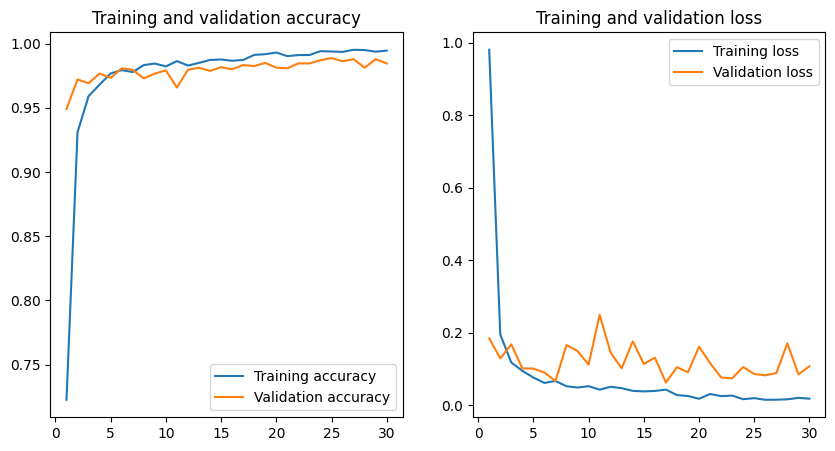

In [ ]:
# Vẽ biểu đồ huấn luyện
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Dựa vào biểu đồ huấn luyện và chỉ số đánh giá trên tập test thì mô hình "Sequential" tốt hơn mô hình Resnet50 => mô hình này được chọn là mô hình tốt nhất cho câu c (Xác định góc quay)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.2f}")

29/29 [==============================] - 7s 188ms/step - loss: 0.0648 - accuracy: 0.9903
Test accuracy: 0.99


#Lưu model

In [ ]:
# drive_path = '/content/gdrive/MyDrive/DeepLearning/Đồ án/HDF5'
# model_hdf5_path = drive_path + '/5Thing_Rotation.hdf5'
# model.save(model_hdf5_path)
# print("Model đã được lưu vào:", model_hdf5_path)

Model đã được lưu vào: /content/gdrive/MyDrive/DeepLearning/Đồ án/5Thing_Rotation.hdf5


#Show prediction


In [ ]:
def show_predictions(dataset, model, class_names):
    count = 0
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
    for images, labels in dataset:
        # Chuyển đổi one-hot encoding thành nhãn
        true_labels = np.argmax(labels, axis=1)

        # Dự đoán trên tập dữ liệu
        predictions = model.predict(images)

        # Chuyển đổi one-hot encoding của dự đoán thành nhãn dự đoán
        predicted_labels = np.argmax(predictions, axis=1)

        # Lấy confidence
        confidence = np.max(predictions, axis=1)

        for i in range(images.shape[0]):  # Use images.shape[0] instead of images_np.shape[0]
            if count >= 10:
                break

            ax = axes[count // 5, count % 5]
            ax.imshow(images[i].numpy().astype(np.uint8))  # Convert EagerTensor to NumPy array

            if predicted_labels[i] == true_labels[i]:
                color = 'g'
            else:
                color = 'r'

            ax.set_title(f"Pred: {class_names[predicted_labels[i]]}-({class_names[true_labels[i]]})({confidence[i]:.2f})", color=color, size=10)
            ax.set(xticks=[], yticks=[])
            count += 1

        if count >= 10:
            break

    title = "Prediction results for images in a batch"
    fig.suptitle(title)
    plt.show()

4/4 [==============================] - 2s 36ms/step


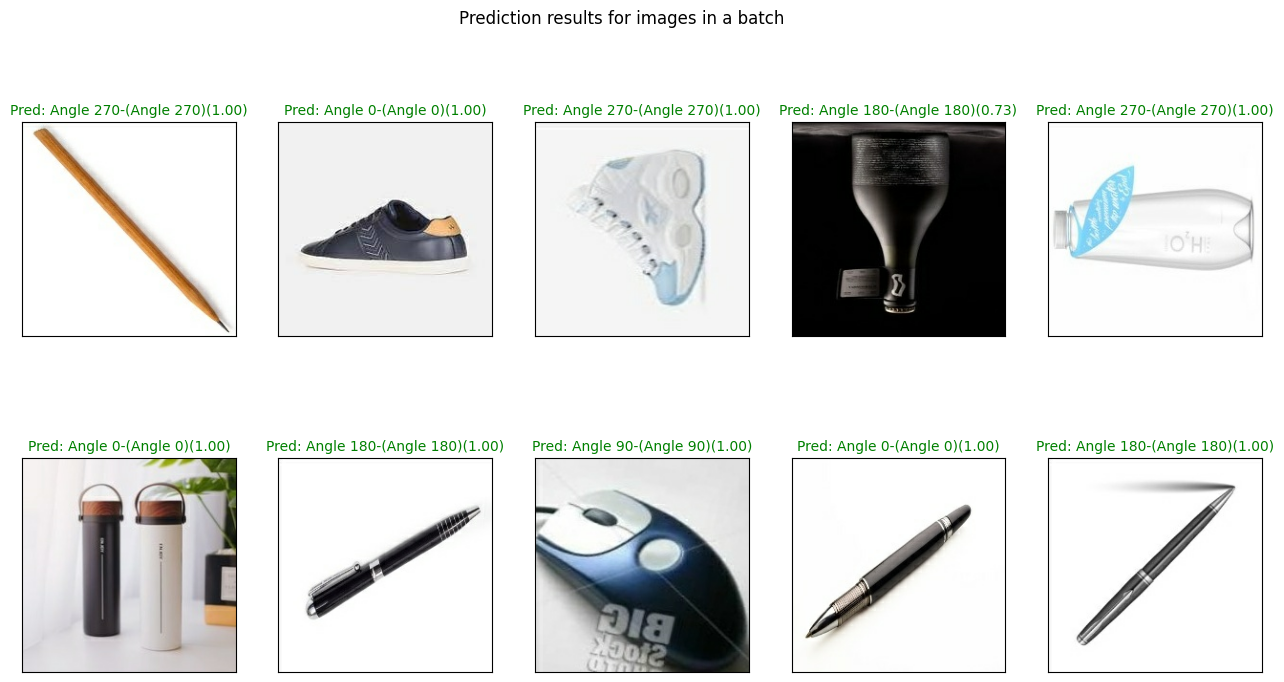

In [ ]:
show_predictions(test_dataset, model, CLASSES)

1/1 [==============================] - 0s 134ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       900
           1       0.99      0.99      0.99       900
           2       1.00      0.99      0.99       900
           3       0.98      0.99      0.98       900

    accuracy                           0.99      3600
   macro avg       0.99      0.99      0.99      3600
weighted avg       0.99      0.99      0.99      3600



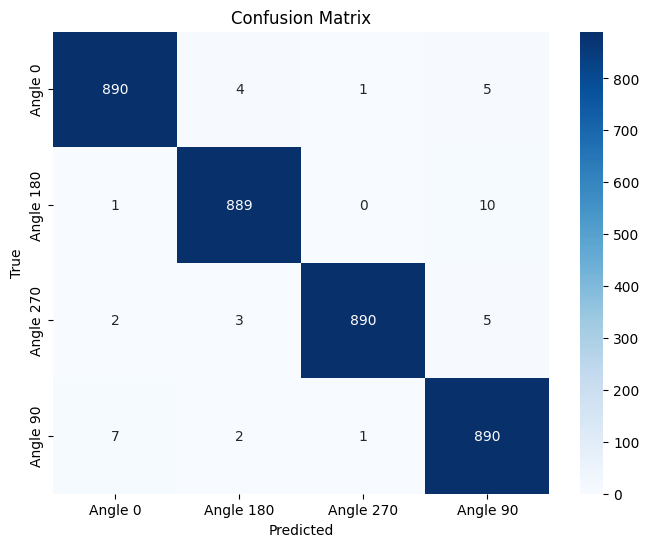

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load model
loaded_model = load_model('5Thing_Rotation.hdf5')

# Function to evaluate and print classification report
def evaluate_model(model, dataset):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot encoding to labels
        predictions = model.predict(images)
        predicted_labels.extend(np.argmax(predictions, axis=1))

    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate on the test dataset
evaluate_model(loaded_model, test_dataset)